In [7]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [9]:
df = pd.read_csv("/Users/ashishkishore/Downloads/Task-2/fraudTrain.csv")

# Exploration

In [10]:
df.shape

(1296675, 23)

In [9]:
df.isnull().values.any()

False

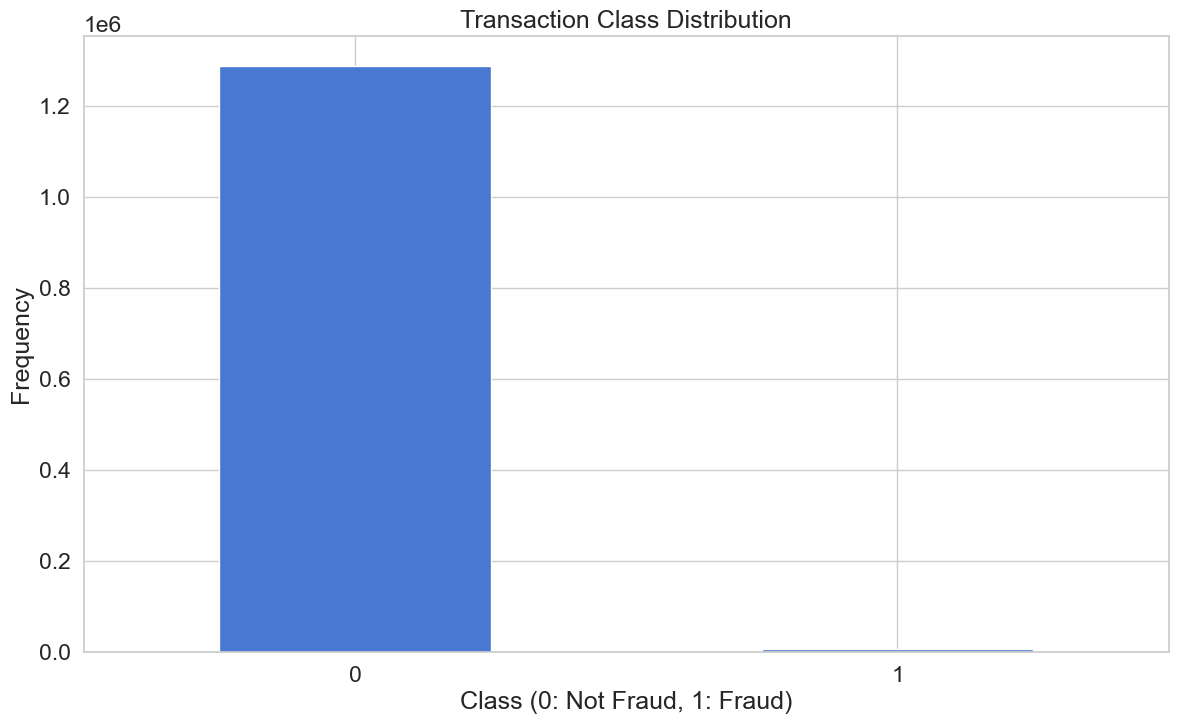

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'Class' with 'is_fraud'
count_classes = pd.value_counts(df['is_fraud'], sort=True)

# Plotting the distribution of classes
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xlabel("Class (0: Not Fraud, 1: Fraud)")
plt.ylabel("Frequency")
plt.show()


In [15]:
# Filter rows based on the 'is_fraud' column
frauds = df[df['is_fraud'] == 1]
normal = df[df['is_fraud'] == 0]


In [16]:
frauds.shape

(7506, 23)

In [17]:
normal.shape

(1289169, 23)

In [19]:
# Get the summary statistics for the 'amt' column in the frauds DataFrame
frauds.amt.describe()


count    7506.000000
mean      531.320092
std       390.560070
min         1.060000
25%       245.662500
50%       396.505000
75%       900.875000
max      1376.040000
Name: amt, dtype: float64

In [21]:
# Get the summary statistics for the 'amt' column in the normal DataFrame
normal.amt.describe()


count    1.289169e+06
mean     6.766711e+01
std      1.540080e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.728000e+01
75%      8.254000e+01
max      2.894890e+04
Name: amt, dtype: float64

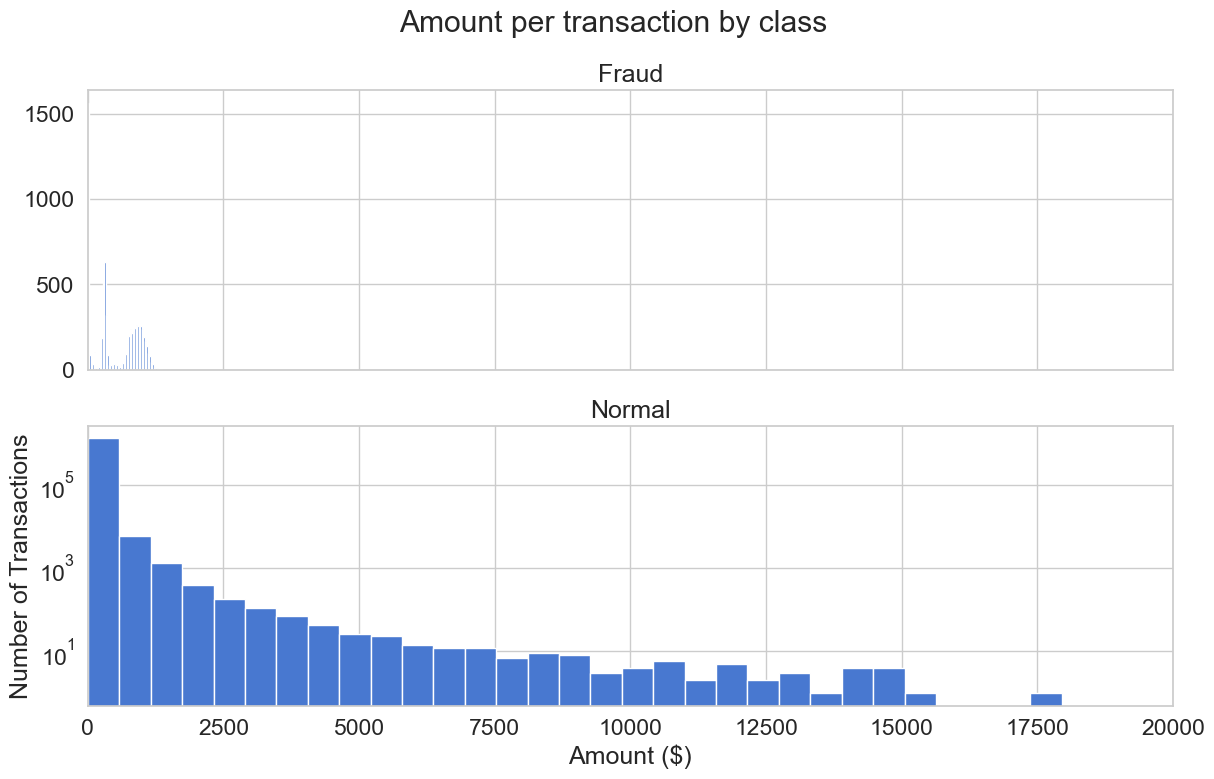

In [23]:
import matplotlib.pyplot as plt

# Create subplots
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

# Plot histograms for fraud and normal transactions
ax1.hist(frauds.amt, bins=bins)
ax1.set_title('Fraud')

ax2.hist(normal.amt, bins=bins)
ax2.set_title('Normal')

# Set common labels and scales
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()


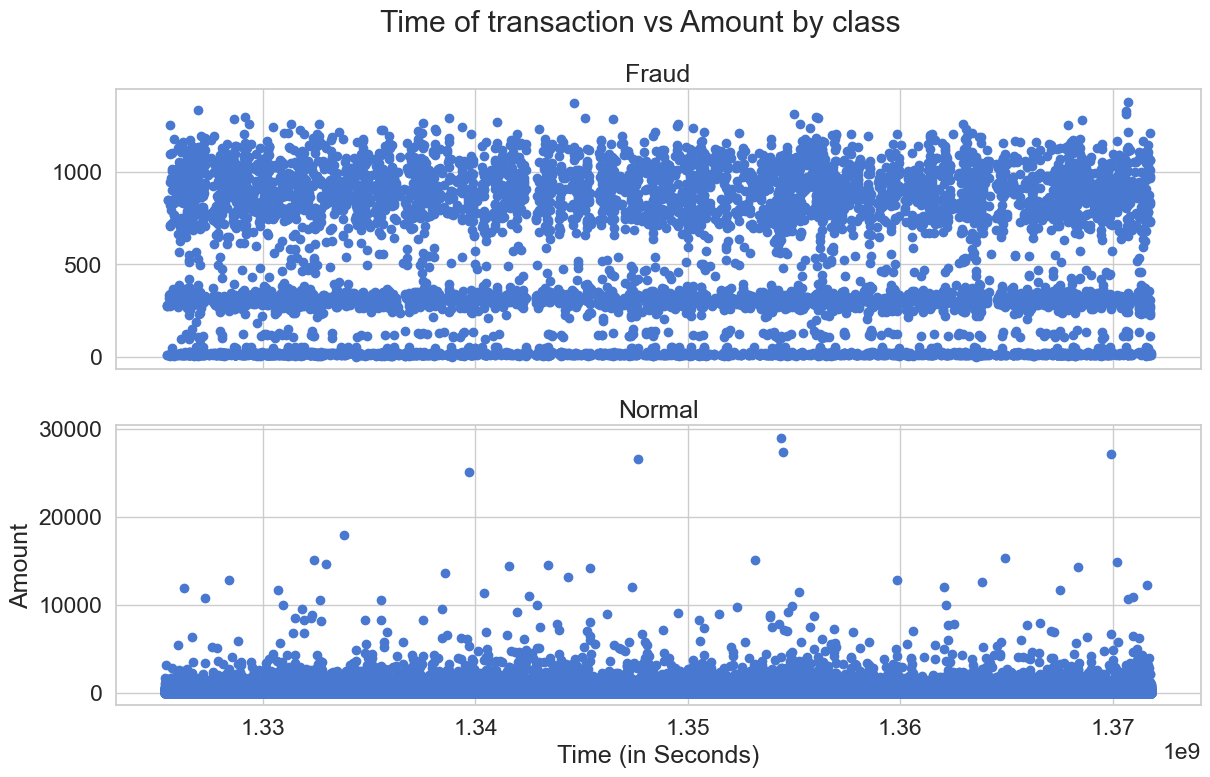

In [25]:
import matplotlib.pyplot as plt

# Create subplots
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

# Plot scatter for fraud transactions using 'unix_time'
ax1.scatter(frauds['unix_time'], frauds['amt'])
ax1.set_title('Fraud')

# Plot scatter for normal transactions using 'unix_time'
ax2.scatter(normal['unix_time'], normal['amt'])
ax2.set_title('Normal')

# Set labels
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


In [36]:
from sklearn.preprocessing import StandardScaler

# Drop the appropriate time column. If you want to drop 'unix_time':
data = df.drop(['unix_time'], axis=1)

# Scale the 'amt' column instead of 'Amount'
data['amt'] = StandardScaler().fit_transform(data['amt'].values.reshape(-1, 1))


In [37]:
from sklearn.model_selection import train_test_split

# Replace 'Class' with 'is_fraud' to match your column name
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

# Filter only the non-fraudulent transactions in the training set
X_train = X_train[X_train['is_fraud'] == 0]

# Drop the 'is_fraud' column from the training set
X_train = X_train.drop(['is_fraud'], axis=1)

# Separate the target variable in the test set
y_test = X_test['is_fraud']
X_test = X_test.drop(['is_fraud'], axis=1)

# Convert the data to numpy arrays for further processing
X_train = X_train.values
X_test = X_test.values


In [38]:
X_train.shape

(1031354, 21)

In [39]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [41]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [46]:
print(data.columns)


Index(['Unnamed: 0', 'cc_num', 'merchant', 'category', 'amt', 'gender', 'zip',
       'lat', 'long', 'city_pop', 'trans_num', 'merch_lat', 'merch_long'],
      dtype='object')


In [47]:
columns_to_drop = ['trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'job', 'dob', 'is_fraud']

# Drop the columns that exist in the DataFrame
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns], axis=1)


In [50]:
# Ensure all columns are numeric
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Scaling the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Split the data
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Convert the data to numpy arrays of type float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Define the autoencoder model with the appropriate input dimension
input_dim = X_train.shape[1]
encoding_dim = 7

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
checkpointer = ModelCheckpoint(filepath="/Users/ashishkishore/Downloads/Task-2/model.keras", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

# Train the model
history = autoencoder.fit(X_train, X_train,
                          epochs=35,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history


Epoch 1/35
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.6705 - loss: 0.4642 - val_accuracy: 0.7816 - val_loss: 0.8234
Epoch 2/35
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - accuracy: 0.7846 - loss: 0.4345 - val_accuracy: 0.7838 - val_loss: 0.8232
Epoch 3/35
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - accuracy: 0.7859 - loss: 0.4284 - val_accuracy: 0.7880 - val_loss: 0.8232
Epoch 4/35
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.7860 - loss: 0.4235 - val_accuracy: 0.7866 - val_loss: 0.8232
Epoch 5/35
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.7865 - loss: 0.4294 - val_accuracy: 0.7845 - val_loss: 0.8232
Epoch 6/35
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.7865 - loss: 0.4279 - val_accuracy: 0.7787 - val_loss: 0.8232
Epoch 7/35
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.7870 - loss: 0.4229 - val_accuracy: 0.7926 - val_loss: 0.8232
Epoch 8/35
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - accuracy: 

In [51]:
# Save the trained model to a file
model_path = "/Users/ashishkishore/Downloads/Task-2/autoencoder_model.h5"
autoencoder.save(model_path)
print(f"Model saved to {model_path}")


Model saved to /Users/ashishkishore/Downloads/Task-2/autoencoder_model.h5


In [52]:
from keras.models import load_model

# Load the model from the saved file
loaded_autoencoder = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


In [53]:
from keras.models import load_model
from keras.optimizers import Adam

# Load the model
autoencoder = load_model('/Users/ashishkishore/Downloads/Task-2/autoencoder_model.h5', compile=False)

# Compile the model with the updated optimizer
autoencoder.compile(optimizer=Adam(learning_rate=0.001), 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

# Model summary
autoencoder.summary()

# Example: Make predictions
predictions = autoencoder.predict(X_test)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │            98 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 13)             │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202 (808.00 B)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

8105/8105 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


# Evaluation

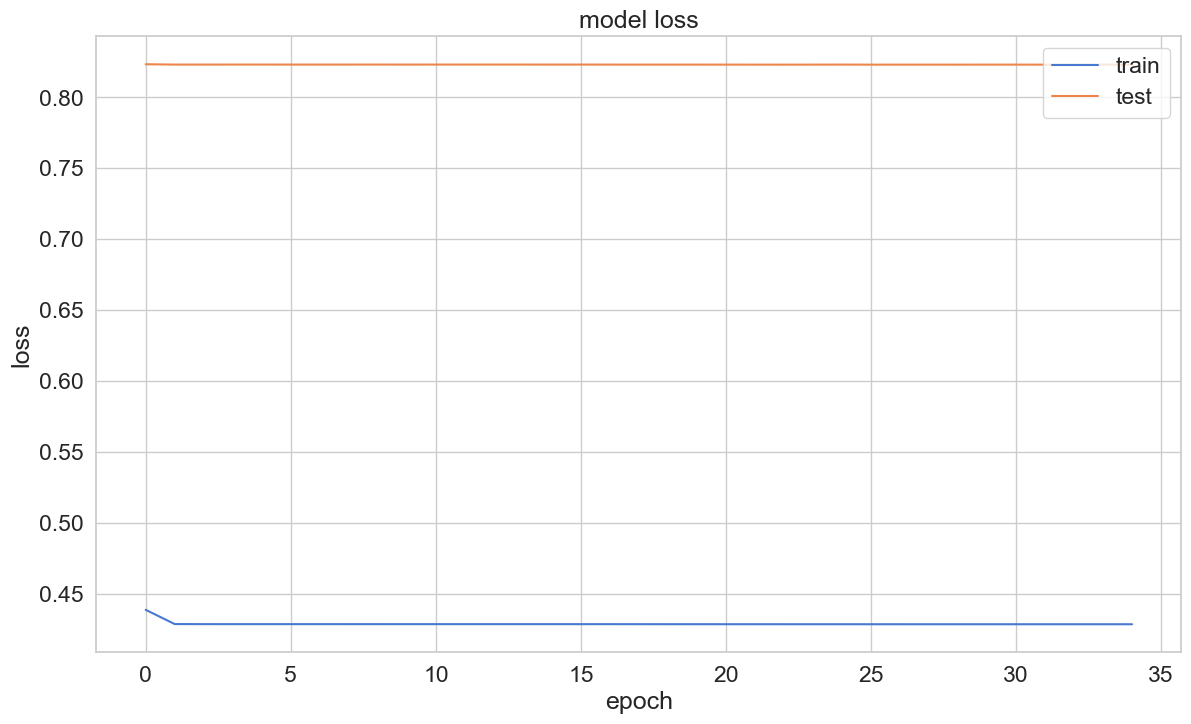

In [54]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [55]:
predictions = autoencoder.predict(X_test)

8105/8105 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


In [56]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [57]:
error_df.describe()

,reconstruction_error,true_class
count,259335.000000,259335.000000
mean,0.823160,0.005861
std,195.861130,0.076334
min,0.008665,0.000000
25%,0.113459,0.000000
50%,0.223172,0.000000
75%,0.450708,0.000000
max,99685.718750,1.000000


## Reconstruction error without fraud

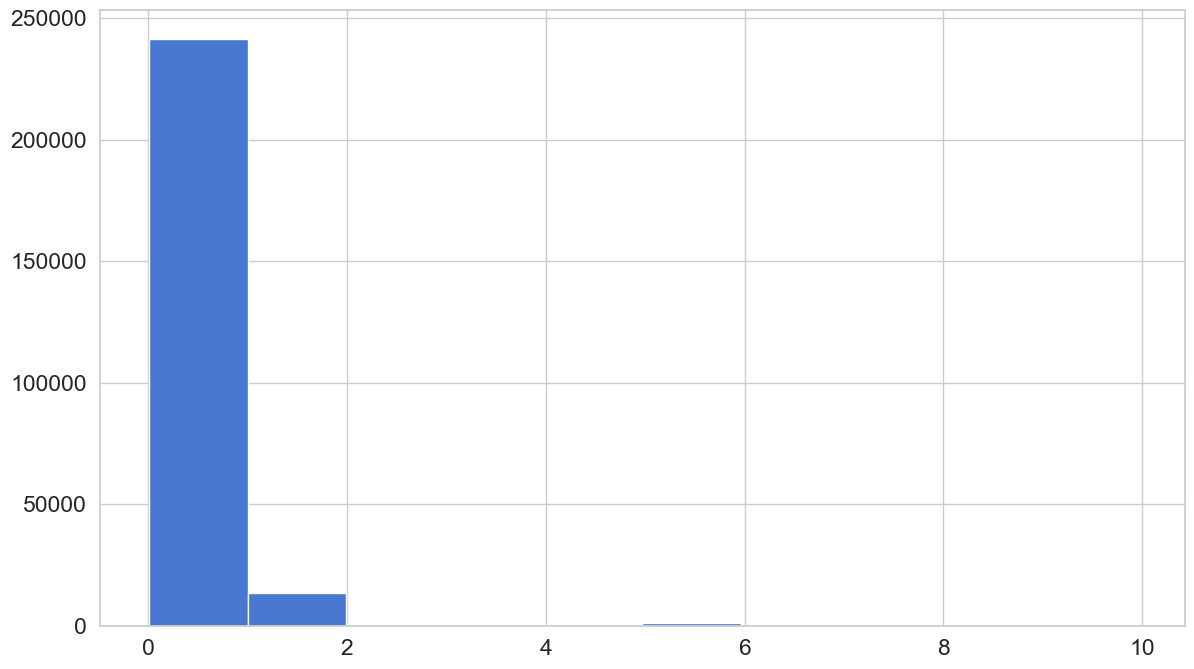

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

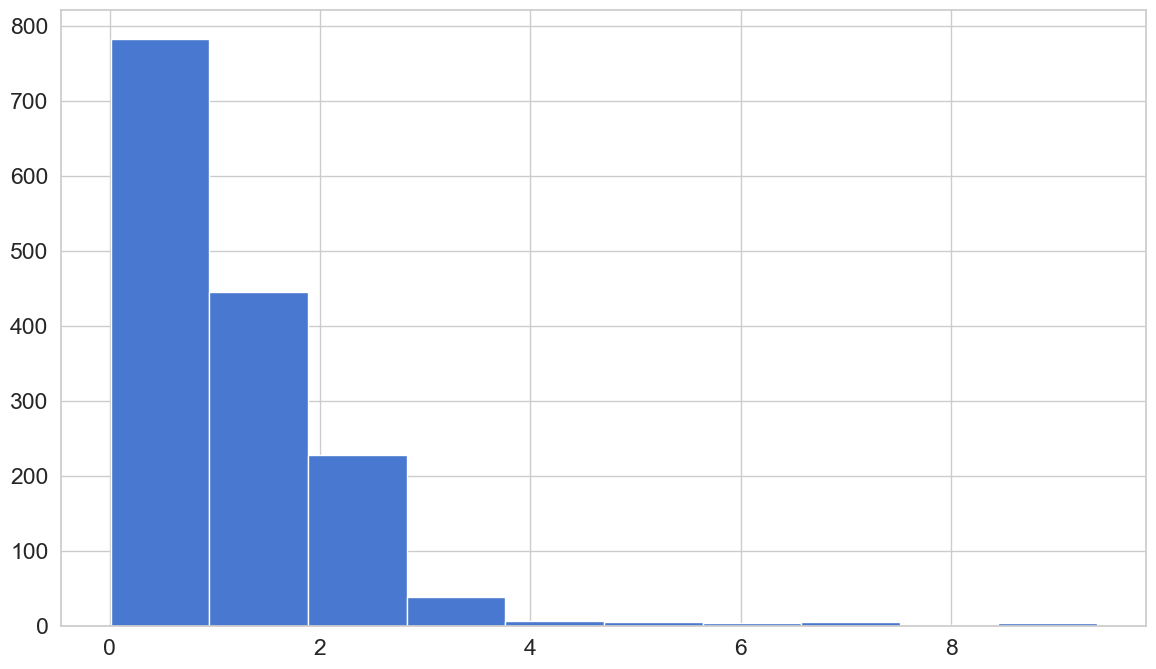

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [60]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

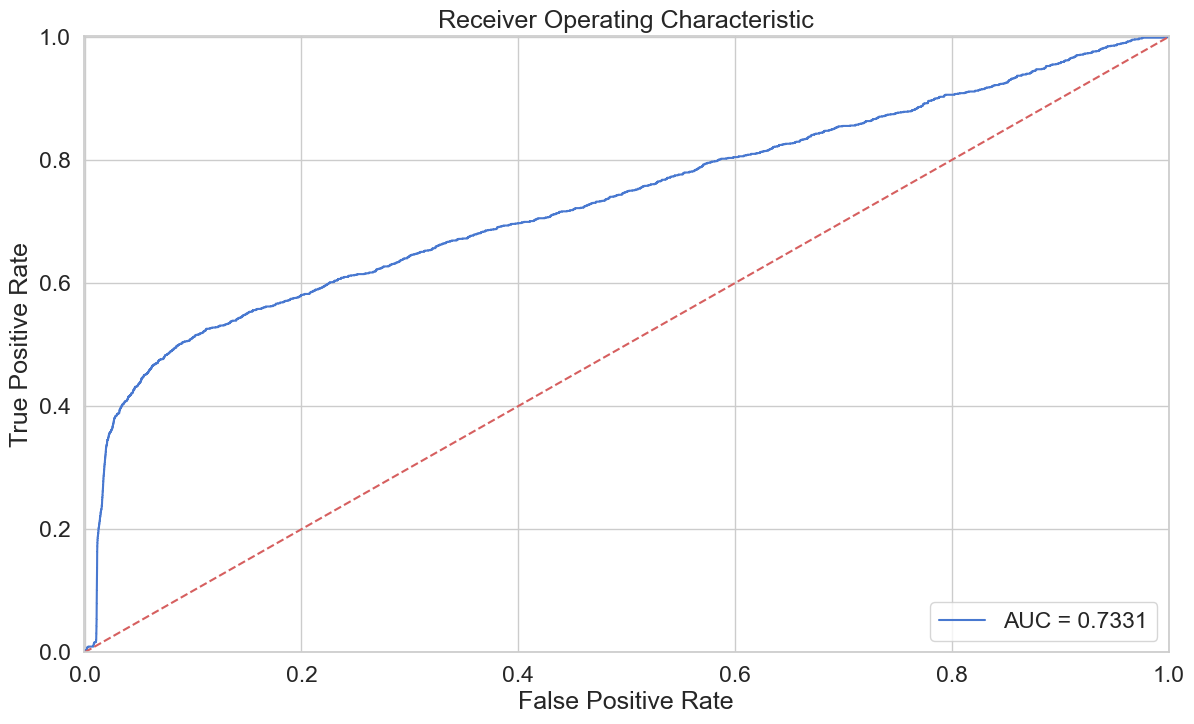

In [61]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

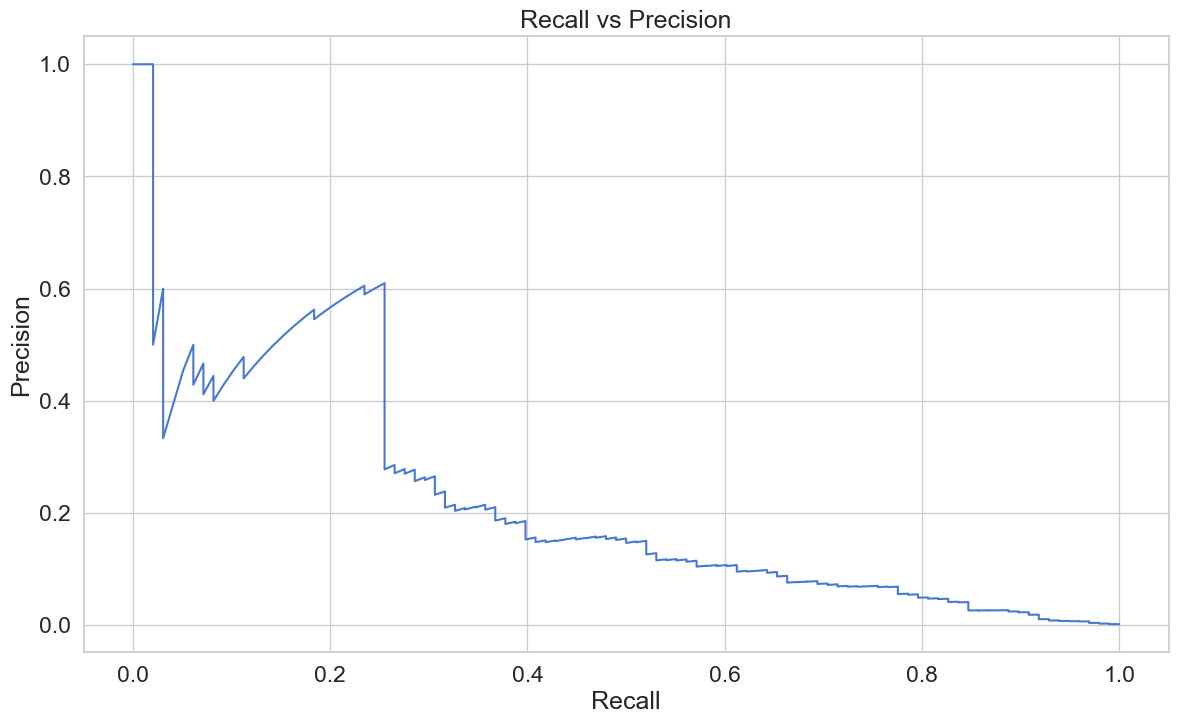

In [43]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

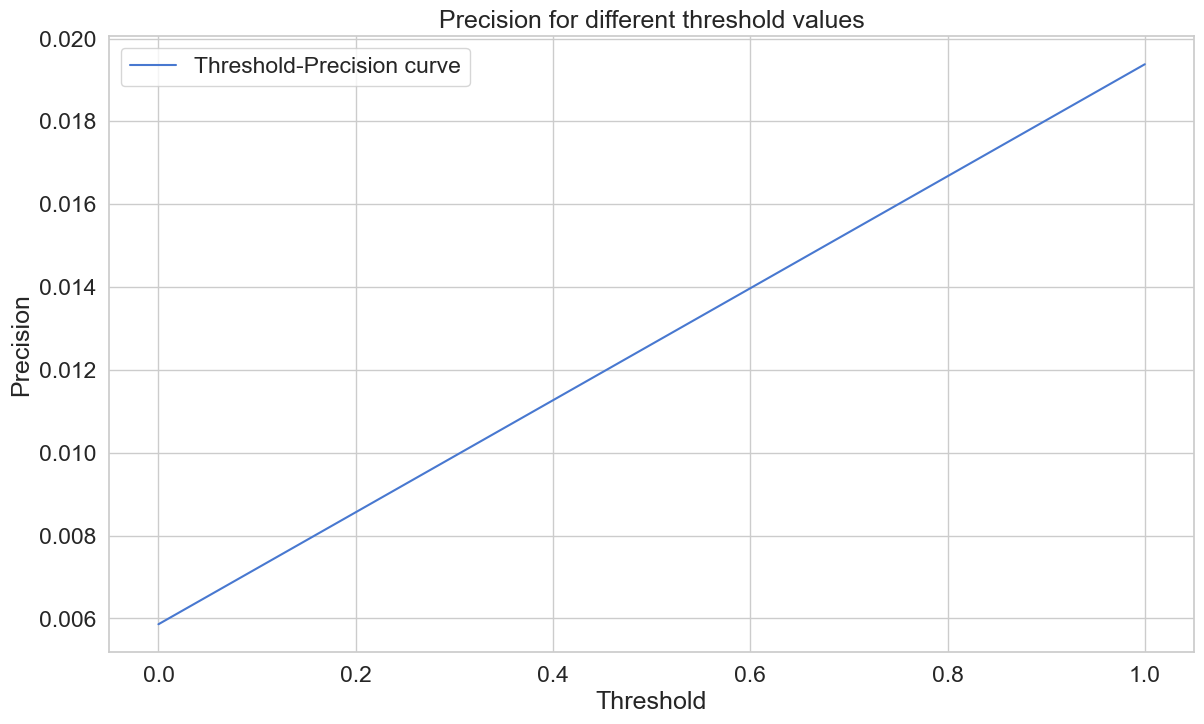

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assuming y_test and y_pred are defined: 
# y_test - ground truth labels (binary)
# y_pred - model predictions (continuous probabilities)

# Calculate precision, recall, and thresholds using sklearn
precision, recall, th = precision_recall_curve(y_test, y_pred)

# Plot the precision for different threshold values
plt.plot(th, precision[:-1], 'b', label='Threshold-Precision curve')  # Note: precision array is 1 longer than threshold
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.legend()
plt.show()


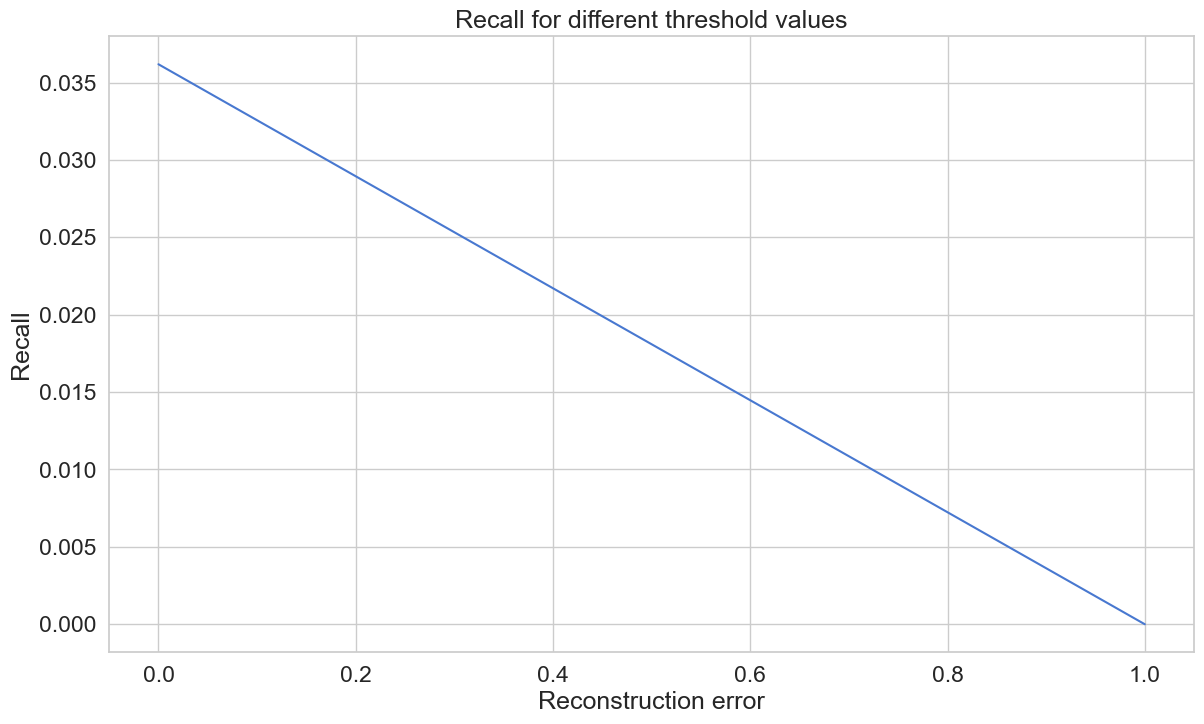

In [67]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [63]:
threshold = 2.9

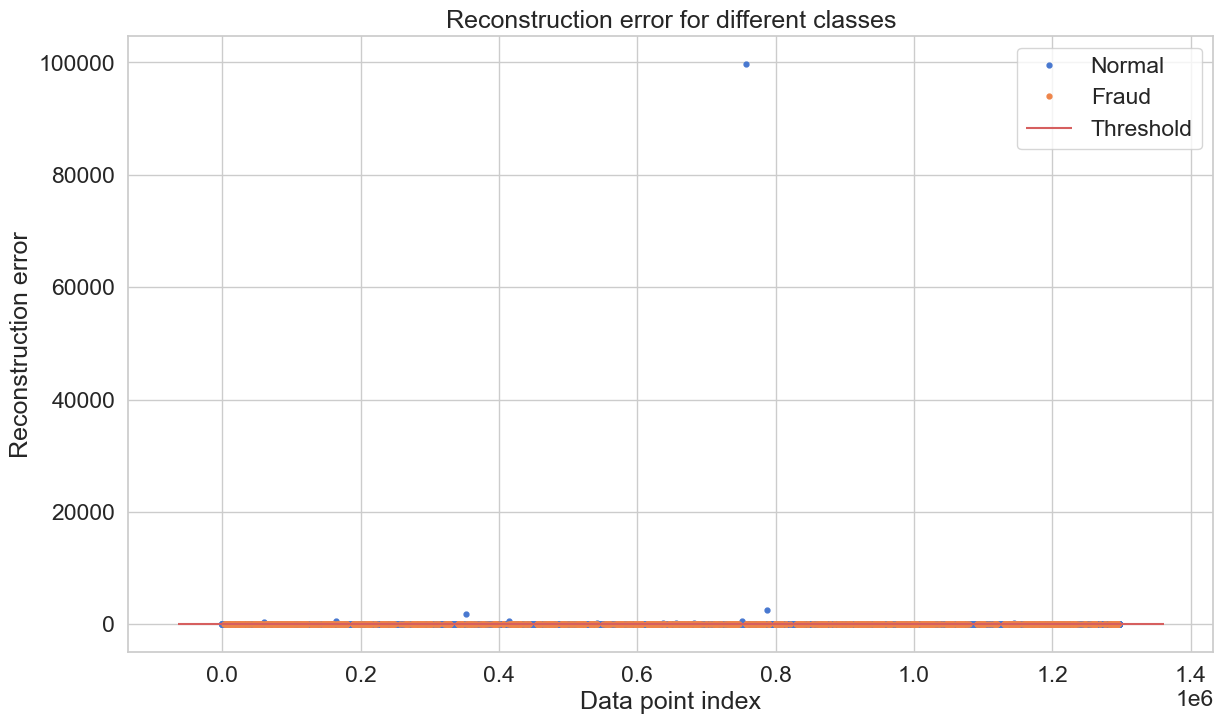

In [68]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

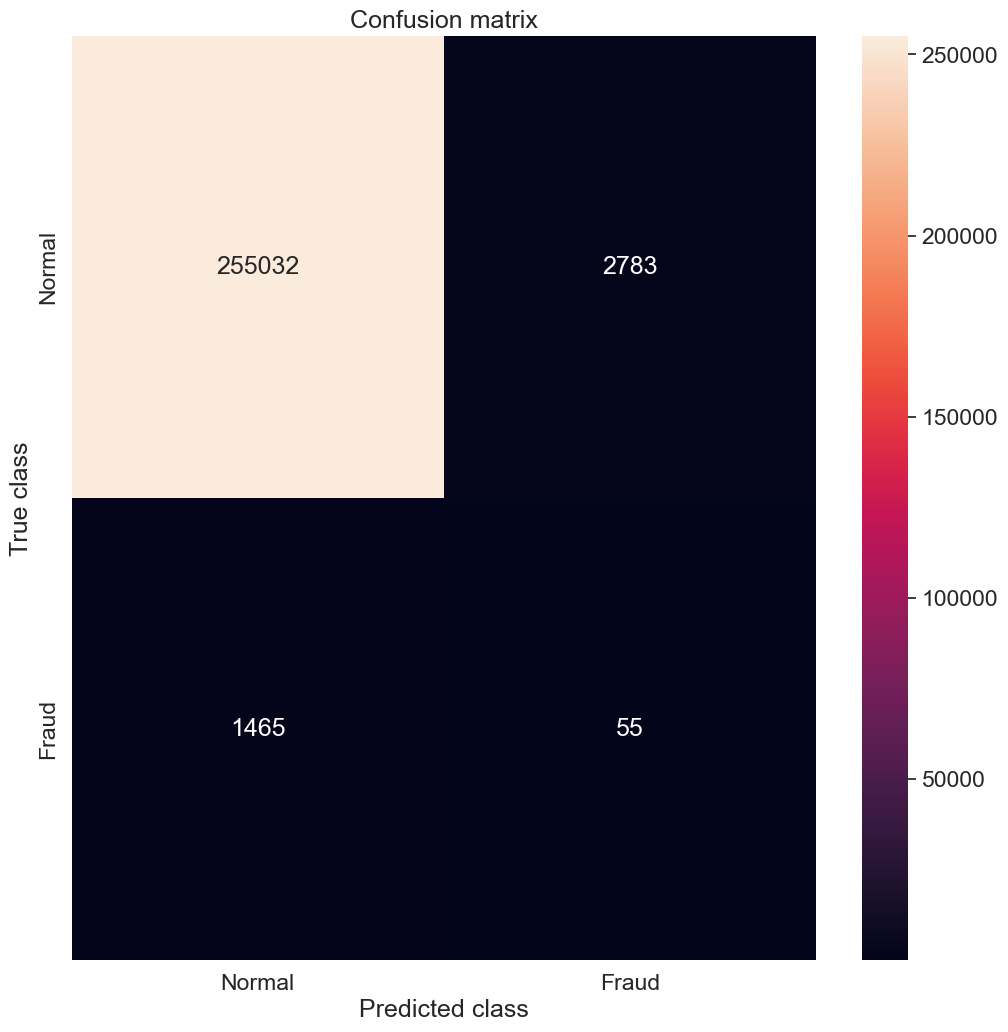

In [65]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()